<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

[breast-histopathology-images](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

https://www.kaggle.com/debajyoti1/cnn-breast-idc

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from glob import glob
import random
from tensorflow import keras
import matplotlib.pyplot as plt

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
mypaths=[]
for name in glob('Inputs/IDC_regular_ps50_idx5/*',recursive=True):
    mypaths.append(name)
print(mypaths[:5])


['Inputs/IDC_regular_ps50_idx5/9036', 'Inputs/IDC_regular_ps50_idx5/10268', 'Inputs/IDC_regular_ps50_idx5/10257', 'Inputs/IDC_regular_ps50_idx5/8913', 'Inputs/IDC_regular_ps50_idx5/13613']


In [3]:
mp=mypaths[60:120]
imagePatches=[]
for i in mp:
    imagePatches+=glob(i+'/*/*.png', recursive=True)


In [5]:
print('total no. of images selected from total images is '+str(len(imagePatches)))


total no. of images selected from total images is 58080


In [6]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)


In [7]:
print('Among them, '+str(len(class0))+' is clss0 and '+str(len(class1))+' is class1')


Among them, 43385 is clss0 and 14695 is class1


In [8]:
sampled_class0 = random.sample(class0, len(class1))
sampled_class1 = random.sample(class1, len(class1))
len(sampled_class0)


14695

In [12]:
from matplotlib.image import imread
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import skimage.io

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = skimage.io.imread(i)
            img_sized = resize(img, (50, 50))
            img_arrays.append([img_sized, label])
    return img_arrays


In [13]:
%%time 
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

CPU times: user 58.1 s, sys: 1.55 s, total: 59.7 s
Wall time: 21.4 s


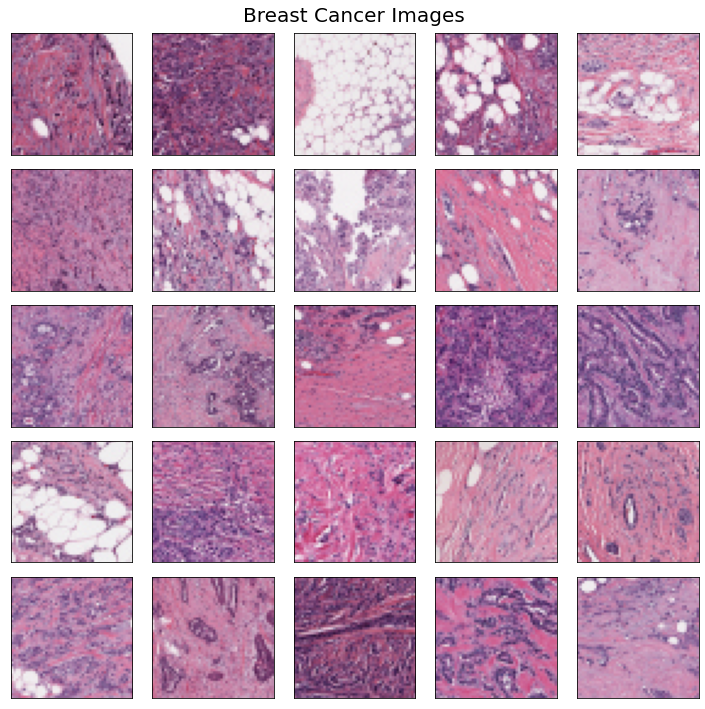

In [78]:

plt.figure(figsize=(10,10))
plt.suptitle("Breast Cancer Images", fontsize=20)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(class1_array[i][0])
#    plt.imshow(train_images[i], cmap=plt.cm.binary)
#    plt.xlabel(class_names[train_labels[i]])

plt.tight_layout()
plt.savefig('Cancer-Images.png')  


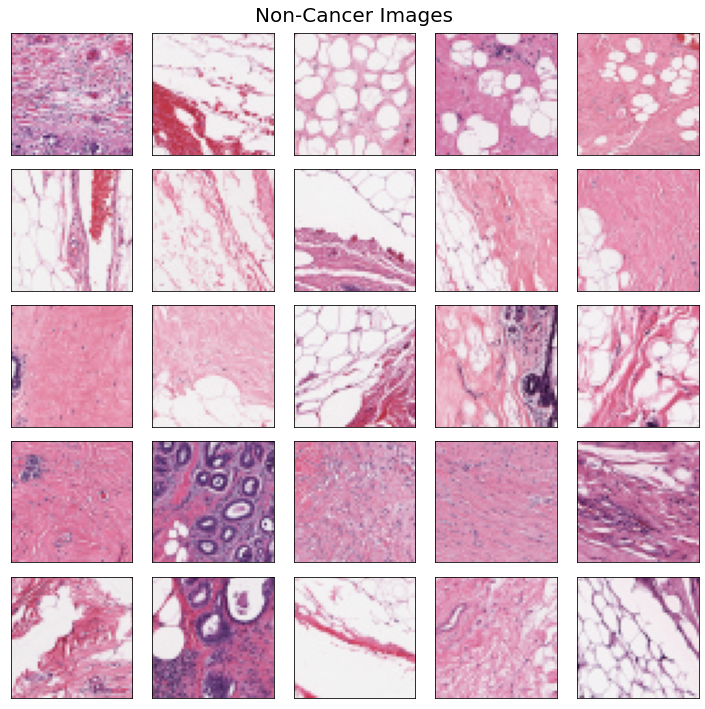

In [77]:
plt.figure(figsize=(10,10))
plt.suptitle("Non-Cancer Images", fontsize=20)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(class0_array[i][0])
#    plt.imshow(train_images[i], cmap=plt.cm.binary)
#    plt.xlabel(class_names[train_labels[i]])
plt.tight_layout()
plt.savefig('non-Cancer-Images.png')  
plt.show()


In [16]:
combined_data = np.concatenate((class0_array, class1_array))

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [17]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [18]:
X = np.array(X).reshape(-1, 50, 50, 3)


In [68]:
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(22042, 50, 50, 3) (7348, 50, 50, 3) (22042, 2) (7348, 2)


In [42]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), 
                        activation='relu', input_shape=(50,50,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(2,2), 
                        activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), 
                        activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), 
                        activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), 
                        activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(9216,input_shape=(12544,), activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])

In [44]:
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall','Precision']
)

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 100)       2800      
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 100)       400       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 100)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 256)       102656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 12, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 384)        

In [46]:
%%time 
history=model.fit(X_train,y_train, 
                  validation_data=(X_test, y_test), batch_size=32,
                  epochs=10)


Epoch 1/10


2021-09-12 15:40:14.354580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


689/689 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7392 - recall: 0.7198 - precision: 0.7208

2021-09-12 15:41:38.171078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


689/689 [==============================] - 90s 130ms/step - loss: 0.5605 - accuracy: 0.7392 - recall: 0.7198 - precision: 0.7208 - val_loss: 0.4521 - val_accuracy: 0.8129 - val_recall: 0.8121 - val_precision: 0.8129
Epoch 2/10
689/689 [==============================] - 91s 132ms/step - loss: 0.4633 - accuracy: 0.8078 - recall: 0.7984 - precision: 0.7990 - val_loss: 0.4173 - val_accuracy: 0.8205 - val_recall: 0.8180 - val_precision: 0.8217
Epoch 3/10
689/689 [==============================] - 91s 132ms/step - loss: 0.4382 - accuracy: 0.8171 - recall: 0.8126 - precision: 0.8124 - val_loss: 0.4097 - val_accuracy: 0.8231 - val_recall: 0.8229 - val_precision: 0.8226
Epoch 4/10
689/689 [==============================] - 91s 132ms/step - loss: 0.4270 - accuracy: 0.8238 - recall: 0.8182 - precision: 0.8180 - val_loss: 0.4042 - val_accuracy: 0.8272 - val_recall: 0.8257 - val_precision: 0.8259
Epoch 5/10
689/689 [==============================] - 93s 135ms/step - loss: 0.4192 - accuracy: 0.8268 

In [47]:
e=model.evaluate(X_test,y_test)

230/230 [==============================] - 6s 27ms/step - loss: 0.3827 - accuracy: 0.8352 - recall: 0.8344 - precision: 0.8359


In [48]:
print(e[0])


0.38270851969718933


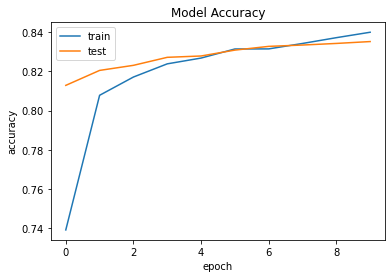

In [49]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

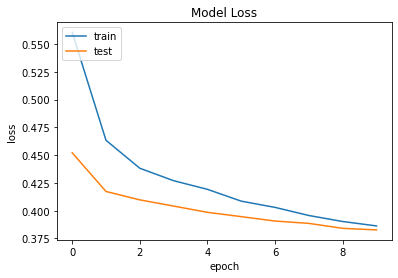

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
y_pred=model.predict(X_test)


2021-09-12 15:55:31.560790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [52]:
y_pred[21]


array([0.86502904, 0.14869645], dtype=float32)

In [53]:
Y_pred=[]
for i in y_pred:
    if i[0]>i[1]:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [54]:
Y_test=[]
for i in y_test:
    if i[0]>i[1]:
        Y_test.append(0)
    else:
        Y_test.append(1)


In [55]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test, Y_pred))
print('Classification Report')
print(classification_report(Y_test, Y_pred, target_names=['Negative','Positive']))


Confusion Matrix
[[3115  564]
 [ 647 3022]]
Classification Report
              precision    recall  f1-score   support

    Negative       0.83      0.85      0.84      3679
    Positive       0.84      0.82      0.83      3669

    accuracy                           0.84      7348
   macro avg       0.84      0.84      0.84      7348
weighted avg       0.84      0.84      0.84      7348



In [56]:
model.save('modelcnn.h5')


In [57]:
confusionmatrix=confusion_matrix(Y_test, Y_pred)
confusionmatrix.shape


(2, 2)

In [58]:
classes=[0,1]
con_mat_df = pd.DataFrame(confusion_matrix(Y_test, Y_pred),
                     index = classes, 
                     columns = classes)
con_mat_df

,0,1
0,3115,564
1,647,3022


In [59]:
import seaborn as sns


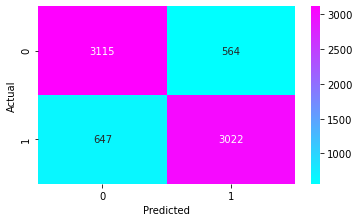

In [70]:
figure = plt.figure(figsize=(5, 3))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
